# Modelling X-ray attenuation

Using python to simulate how an X-ray beam is attenuated, using the Beer-Lambert law, and visualising the resulting attenuation profiles.

### Single-layer attenuation
**Beer-Lambert Law**: <br>
$ I = I_0 \cdot e^{\mu x} $

Where: <br>
- I: intensity after passing through material
- $I_0$ : Initial intensity
- $\mu$ : Linear attenuation coefficient
- $x$ : Thickness 

This is easily generalised to multiple layers, however one key limitation is that this assumes monochromatic electromagnetic radiation is used. In x-ray imaging, we observe 'beam hardening', when the x-ray beam comprised of polychromatic energies passes through the object. As the high energy 'hard' x-rays, can penetrate denser materials better than 'soft' x-rays. 

I decided to download a python library SpekPy to model the radiation spectra from x ray tubes. [A validation of SpekPy](https://www.sciencedirect.com/science/article/pii/S1120179720301083?via%3Dihub)

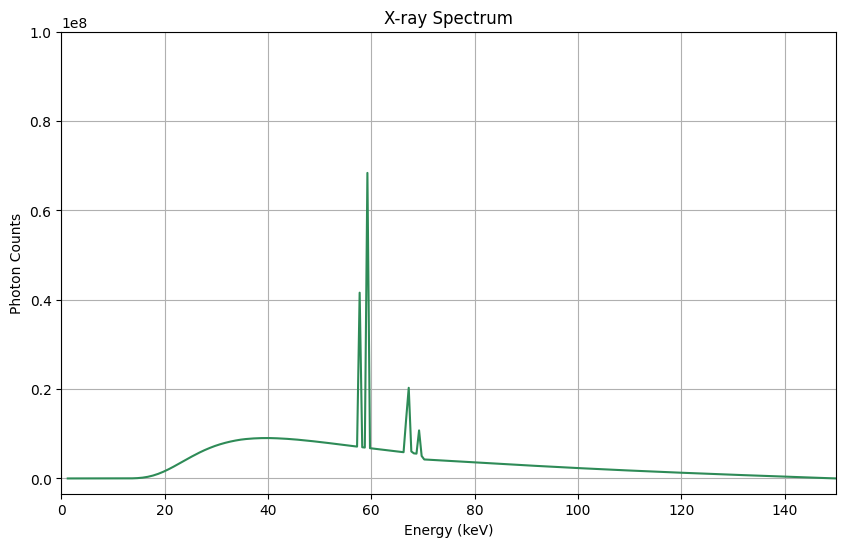

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spekpy as sp
import pandas as pd

s = sp.Spek(kvp=150,th=12) # Generate a spectrum (150 kV, 12 degree tube angle)

s.filter('Al', 2.0)

energies = s.get_k() # get energy bins
photon_counts = s.get_spk() # get photon counts

plt.figure(figsize=(10, 6)) 
plt.plot(energies, photon_counts, linestyle='-', color='seagreen')
plt.xlim(0, 150)
plt.ylim(top=1e8)
plt.xlabel("Energy (keV)")
plt.ylabel("Photon Counts")
plt.title("X-ray Spectrum")
plt.grid(True)
plt.show()

The default target material SpekPy uses is Tungesten. [Resource I used](https://doi.org/10.1002/mp.14945)

The sharp peaks correspond to Tungestens characteristic radiations [Guide](https://rigaku.com/products/imaging-ndt/x-ray-ct/learning/blog/what-is-beam-hardening-in-ct)

Ignoring these peaks we can see the peak is around 31 keV. I have restricted the values of the energy spectrum to avoid the high peaks at low energies. These sharp peaks are monochromatic- so we don't expect to see any beam hardening. At this point I could use SpekPy's filter function in order to simulate the x-rays interacting with a material, but I would like to try implement this myself.

I copied in some attenuation coefficients for bone from [NIST](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html) and had to interpolate the data as I had less data points for attenuation coefficients.

Original peak: 39.8 keV
After bone attenuation: 49.8 keV
Mean energy before attenuation: 60.27 keV
Mean energy after attenuation: 67.27 keV
Spectral Hardness Ratio before attenuation: 0.6110
Spectral Hardness Ratio after attenuation: 0.7434


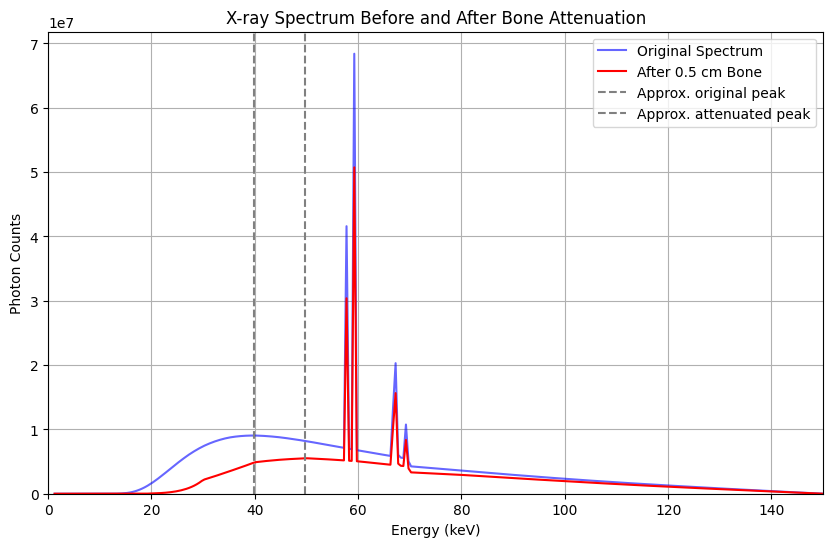

In [6]:
import pandas as pd
from scipy.interpolate import interp1d

# Load csv
bone_data = pd.read_csv(r"../data/bone.csv", names=["Energy_MeV", "Mu_Rho"], header=None)#

# Convert energy to KeV
bone_data["Energy_KeV"] = bone_data["Energy_MeV"] * 1000

# Average out duplicates by grouping
bone_data = bone_data.groupby("Energy_KeV", as_index=False).mean()

# Convert to linear attenuation (mu = mu/rho * rho)
bone_density = 1.85  # g/cm^3
bone_data["Mu"] = bone_data["Mu_Rho"] * bone_density  # [cm^-1]
mu = bone_data["Mu"].to_numpy()

# Create interpolation function for attenuation coefficients
mu_interp = interp1d(bone_data["Energy_KeV"], bone_data["Mu"], bounds_error=False, fill_value="extrapolate")

mu_at_spectrum_energies = mu_interp(energies)

thickness_cm = 0.5
I0 = s.get_spk()

I_filtered = I0 * np.exp(-mu_at_spectrum_energies * thickness_cm)

# Mask to energies below 50 keV (to avoid tungsten peaks)
mask = (energies < 50)
E0_peak = energies[mask][np.argmax(I0[mask])]
E1_peak = energies[mask][np.argmax(I_filtered[mask])]

print(f"Original peak: {E0_peak:.1f} keV")
print(f"After bone attenuation: {E1_peak:.1f} keV")

# Mean photon energy before attenuation
mean_energy_before = np.sum(energies * I0) / np.sum(I0)

# Mean photon energy after attenuation
mean_energy_after = np.sum(energies * I_filtered) / np.sum(I_filtered)

print(f"Mean energy before attenuation: {mean_energy_before:.2f} keV")
print(f"Mean energy after attenuation: {mean_energy_after:.2f} keV")

# Define threshold
threshold = 50  # keV

# Compute SHR before attenuation
shr_before = np.sum(I0[energies > threshold]) / np.sum(I0)

# Compute SHR after attenuation
shr_after = np.sum(I_filtered[energies > threshold]) / np.sum(I_filtered)

print(f"Spectral Hardness Ratio before attenuation: {shr_before:.4f}")
print(f"Spectral Hardness Ratio after attenuation: {shr_after:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(energies, I0, label="Original Spectrum", color="blue", alpha=0.6)
plt.plot(energies, I_filtered, label="After 0.5 cm Bone", color="red")
plt.axvline(x=E0_peak, color='gray', linestyle='--', label="Approx. original peak")
plt.axvline(x=E1_peak, color='gray', linestyle='--', label="Approx. attenuated peak")
plt.xlabel("Energy (keV)")
plt.ylabel("Photon Counts")
plt.title("X-ray Spectrum Before and After Bone Attenuation")
plt.grid(True)
plt.legend()
plt.xlim(0, 150)
plt.ylim(bottom=0)
plt.show()


My next goal is to generalise this to multiple materials, using:<br>

$I = I_0 \cdot e^{- \sum_{i}^{} \mu_i (E) \cdot d_i}$

I first wrote a function repeating what I had done so that I could load NIST data for other materials, provided I made a csv file for them.

[NIST Soft Tissue](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/tissue.html)

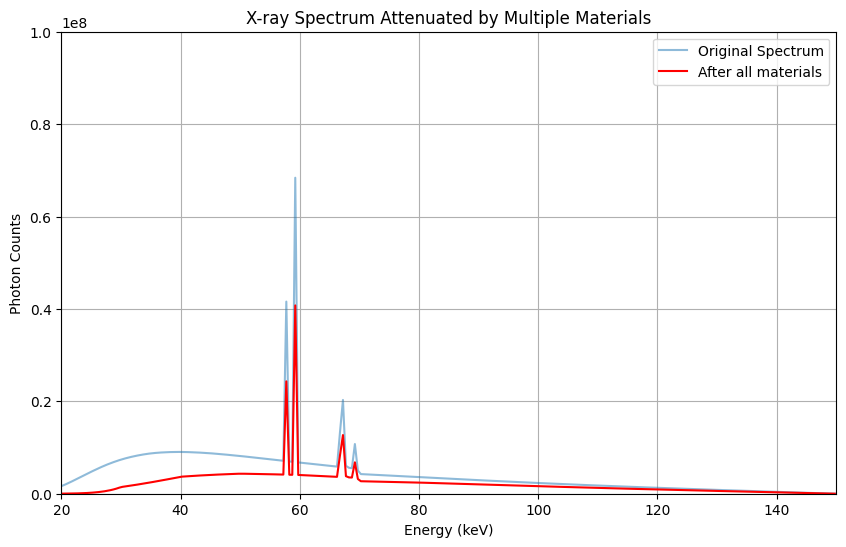

In [7]:
def load_mu_data(csv_path, density, energy_range_KeV):
    import pandas as pd
    from scipy.interpolate import interp1d

    df = pd.read_csv(csv_path, names=["Energy_MeV", "Mu_Rho"], header=None)
    df["Energy_keV"] = df["Energy_MeV"] * 1000
    df = df.groupby("Energy_keV", as_index=False).mean()
    df["Mu"] = df["Mu_Rho"] * density

    interp_mu = interp1d(df["Energy_keV"], df["Mu"], bounds_error=False, fill_value="extrapolate")
    return interp_mu(energy_range_KeV)

energies = s.get_k()  # energy array (keV)

# Load each material
mu_bone = load_mu_data(r"../data/bone.csv", density=1.85, energy_range_KeV=energies)
mu_tissue = load_mu_data(r"../data/soft_tissue.csv", density=1.06, energy_range_KeV=energies)


# Define thicknesses (cm)
thickness_bone = 0.5
thickness_tissue = 1.0

# Total attenuation coefficient
mu_total = np.add((mu_bone*thickness_bone),(mu_tissue*thickness_tissue))

# Apply Beer-Lambert
I0 = s.get_spk()
I_filtered = I0 * np.exp(-mu_total)


plt.figure(figsize=(10, 6))
plt.plot(energies, I0, label="Original Spectrum", alpha=0.5)
plt.plot(energies, I_filtered, label="After all materials", color="red")
plt.xlabel("Energy (keV)")
plt.ylabel("Photon Counts")
plt.title("X-ray Spectrum Attenuated by Multiple Materials")
plt.xlim(20, 150)
plt.ylim(bottom=0,top=1e8)
plt.grid(True)
plt.legend()
plt.show()

The next goal for me was to recreate a simple 2D cross-section of tissue (phantom), and simulate how an X-ray beam (coming from top down) would attenuate as it passes through it from one side.

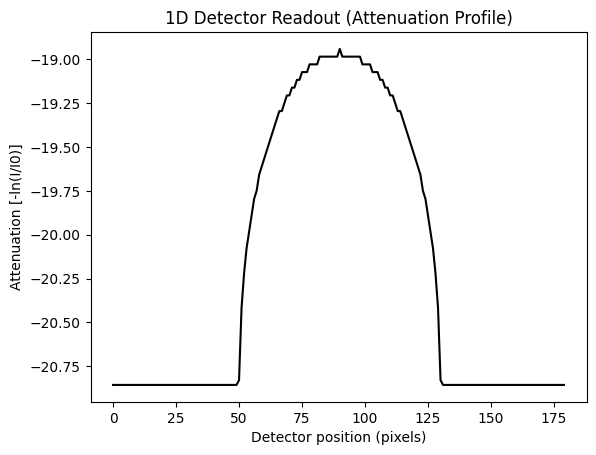

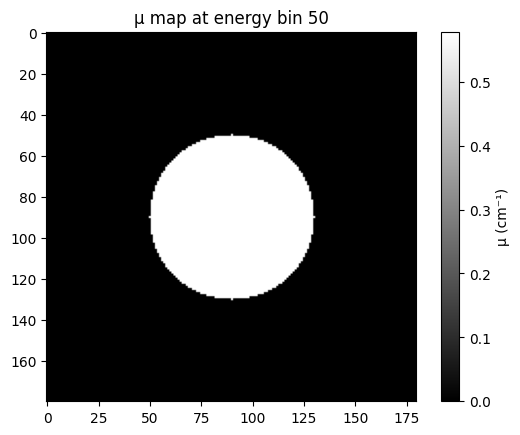

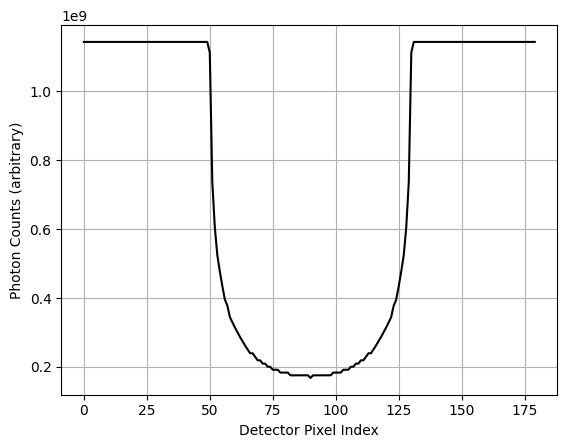

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# image size
width, height = 180,180
E = len(energies)

# Add a circular bone
y, x = np.ogrid[:height, :width]
center_x, center_y = width//2, height//2
boneradius = 10
thighradius = 40
bonemask = (x-center_x)**2 + (y-center_y)**2 <= boneradius**2

phantom = np.zeros((height, width, E))

thighmask = (x-center_x)**2 + (y-center_y)**2 <= thighradius**2

# Background
phantom[:, :, :] = 0  # broadcast over all pixels

# Thigh region
phantom[thighmask, :] = mu_tissue

pixel_thickness_cm = 0.1 # Assume each pixel is 0.1cm thick

# Sum attenuation coefficients along the ray path (top to bottom) for each (width, energy).
# 'mu_total' is 2D (width, energy), representing total attenuation per ray per energy.
mu_total = phantom.sum(axis=0)

I = I0 * np.exp(-mu_total * pixel_thickness_cm)

# Sum transmitted intensities across all energies for each detector position.
# 'detector_readout' is 1D (width,), representing the final polychromatic projection profile.
detector_readout = I.sum(axis=1)

# Visualize attenuation (log form)
attenuation_profile = -np.log(detector_readout + 1e-6)  # add epsilon to avoid log(0)
plt.plot(attenuation_profile, color='black')
plt.xlabel('Detector position (pixels)')
plt.ylabel('Attenuation [-ln(I/I0)]')
plt.title('1D Detector Readout (Attenuation Profile)')
plt.show()

energy_idx = 50  # e.g. energy bin index
plt.imshow(phantom[:, :, energy_idx], cmap='gray')
plt.title(f"μ map at energy bin {energy_idx}")
plt.colorbar(label="μ (cm⁻¹)")
plt.show()

plt.plot(detector_readout, color="black")
plt.title("")
plt.xlabel("Detector Pixel Index")
plt.ylabel("Photon Counts (arbitrary)")
plt.grid(True)
plt.show()

I then just needed to rotate the image using scipy and I have recreated a ct scan. The challenge in this, is reconstructing the scan https://rigaku.com/products/imaging-ndt/x-ray-ct/learning/blog/how-does-ct-reconstruction-work

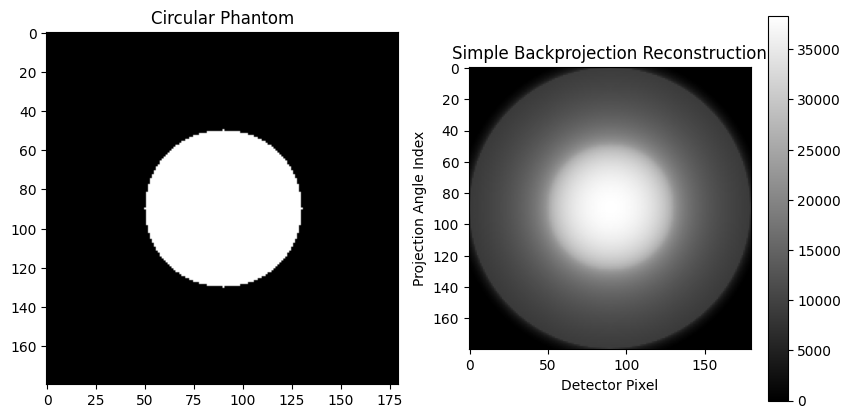

In [ ]:
from scipy import ndimage

angles = np.linspace(0, 180, num=180)
sinogram_circle = np.zeros((len(angles), 180))  # (n_angles, width)

for i, angle in enumerate(angles):
    # Rotate the 3D phantom (H, W, E) around axes (1, 0) → rotates H-W plane, all energies together
    rotated_phantom = ndimage.rotate(phantom, angle, axes=(1, 0), reshape=False, order=1)
    
    # Sum along the y-axis (axis=1), result is (width, E)
    projection_per_energy = rotated_phantom.sum(axis=1)  # shape: (W, E)
    
    # Line integrals: ln(I0 / I) = μ * dx
    # projection_per_energy already equals ∑μ dx per ray per energy
    line_integrals = projection_per_energy * pixel_thickness_cm  # shape (W, E)
    sinogram_circle[i] = line_integrals.sum(axis=1)  # shape: (n_angles, W, E)

sinogram_circle = np.array(sinogram_circle)  # shape: (n_angles, W)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(phantom[:, :, energy_idx], cmap='gray')
axs[0].set_title("Circular Phantom")

axs[1].imshow(sinogram_circle.T, cmap='gray', aspect='auto', vmin=np.percentile(sinogram_circle, 5), vmax=np.percentile(sinogram_circle, 95))
axs[1].set_title("Sinogram")
axs[1].set_xlabel("Detector Pixel")
axs[1].set_ylabel("Projection Angle Index")

# Initialize reconstruction
creconstruction = np.zeros((180, 180))

# Backproject each angle's projection
for i, angle in enumerate(angles):
    # Expand the 1D projection into a 2D image by smearing along the angle
    projection = sinogram_circle[i]
    expanded = np.tile(projection, (180, 1))  # Repeat along y-axis
    
    # Rotate back to original angle and accumulate
    rotated_back = ndimage.rotate(expanded, -angle, reshape=False, order=1)
    creconstruction += rotated_back

# Normalize
creconstruction /= len(angles)

plt.imshow(creconstruction, cmap='gray')
plt.title("Simple Backprojection Reconstruction")
plt.colorbar()
plt.show()

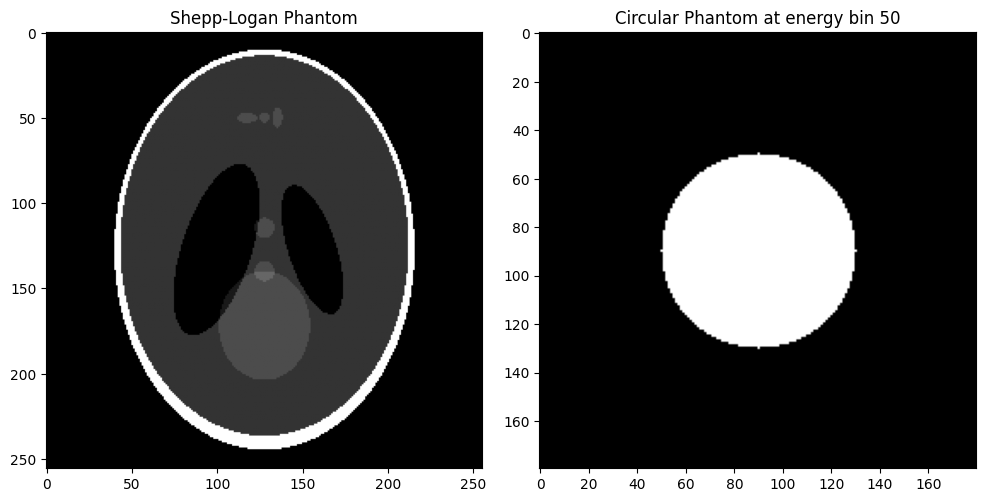

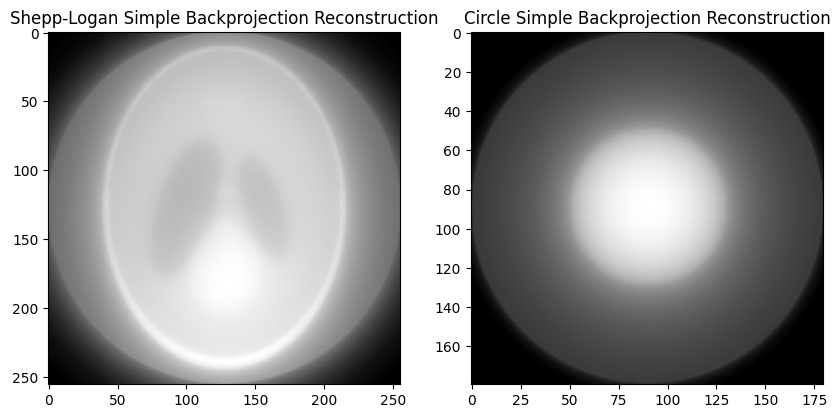

MSE: 0.3778
PSNR: 4.23 dB
SSIM: 0.3130


In [10]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import phantomgen as pg
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

P = pg.phantom()  # Assume shape (H, W)
I0 = 1
pixel_thickness_cm = 0.1  # Define appropriately
height = P.shape[0]
width = P.shape[1]

angles = np.linspace(0, 180, num=180)
sinogram = np.zeros((len(angles), width))

for i, angle in enumerate(angles):
    rotated = ndimage.rotate(P, angle, axes=(1, 0), reshape=False, order=1)
    projection = rotated.sum(axis=0)
    I = np.exp(-projection * pixel_thickness_cm)
    sinogram[i] = -np.log(I + 1e-6)  # gives line integral (as in CT)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(P, cmap='gray')
axs[0].set_title("Shepp-Logan Phantom")

axs[1].imshow(phantom[:, :, energy_idx], cmap='gray')
axs[1].set_title("Circular Phantom at energy bin 50")


#axs[1].imshow(sinogram, cmap='gray')
#axs[1].set_title("Sinogram")
#axs[1].set_xlabel("Detector Pixel")
#axs[1].set_ylabel("Projection Angle Index")

plt.tight_layout()
plt.show()

# Initialize reconstruction
reconstruction = np.zeros((width, height))

# Backproject each angle's projection
for i, angle in enumerate(angles):
    # Expand the 1D projection into a 2D image by smearing along the angle
    projection = sinogram[i]
    expanded = np.tile(projection, (width, 1))  # Repeat along y-axis
    
    # Rotate back to original angle and accumulate
    rotated_back = ndimage.rotate(expanded, -angle, reshape=False, order=1)
    reconstruction += rotated_back

# Normalize
reconstruction /= len(angles)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(reconstruction, cmap='gray')
axs[0].set_title("Shepp-Logan Simple Backprojection Reconstruction")

axs[1].imshow(creconstruction, cmap='gray')
axs[1].set_title("Circle Simple Backprojection Reconstruction")

plt.show()

def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def circular_mask(shape):
    center = np.array(shape) // 2
    Y, X = np.ogrid[:shape[0], :shape[1]]
    dist_sq = (X - center[1])**2 + (Y - center[0])**2
    radius = min(center)
    return dist_sq <= radius**2

phantom_norm = normalize(P)
reconstruction_norm = normalize(reconstruction)

mask = circular_mask(phantom_norm.shape)

phantom_masked = phantom_norm[mask]
reconstruction_masked = reconstruction_norm[mask]

# MSE and PSNR work on flat arrays
mse_val = mean_squared_error(phantom_masked, reconstruction_masked)
psnr_val = peak_signal_noise_ratio(phantom_masked, reconstruction_masked, data_range=1.0)  # Already normalized

# SSIM needs 2D input, so we mask the full image before passing to SSIM
phantom_masked_img = np.copy(phantom_norm)
reconstruction_masked_img = np.copy(reconstruction_norm)
phantom_masked_img[~mask] = 0
reconstruction_masked_img[~mask] = 0

ssim_val, _ = structural_similarity(
    phantom_masked_img, reconstruction_masked_img,
    data_range=1.0, full=True
)

# Print them
print(f"MSE: {mse_val:.4f}")
print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")


In [ ]:
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

angles = np.linspace(0, 180, num=180, endpoint=False)
sinogram_circle = np.zeros((len(angles), phantom.shape[0]))

for i, angle in enumerate(angles):
    rotated_phantom = ndimage.rotate(phantom, angle, axes=(1, 0), reshape=False, order=1)
    
    projection_per_energy = rotated_phantom.sum(axis=1)
    line_integrals = projection_per_energy * pixel_thickness_cm 
    sinogram_circle[i] = line_integrals.sum(axis=1)

sinogram_circle = np.array(sinogram_circle)

# --- Filtered Backprojection Implementation ---

projection_len = sinogram_circle.shape[1]
padded_len = int(2**np.ceil(np.log2(2 * projection_len))) 

padded_len = max(padded_len, projection_len)

freq = fftfreq(padded_len)
ramlak_filter = 2 * np.abs(freq) # Ram-Lak filter, multiplied by 2 as is common

# Initialize reconstruction
creconstruction_fbp = np.zeros((180, 180))

# Backproject each angle's *filtered* projection
for i, angle in enumerate(angles):
    projection = sinogram_circle[i]
    
    # 1. Pad the projection
    padded_projection = np.pad(projection, (0, padded_len - projection_len), 'constant')
    
    # 2. Fourier Transform the padded projection
    proj_fft = fft(padded_projection)
    
    # 3. Apply the Ram-Lak filter in the frequency domain
    filtered_proj_fft = proj_fft * ramlak_filter
    
    # 4. Inverse Fourier Transform to get the filtered projection in spatial domain
    filtered_projection_spatial = np.real(ifft(filtered_proj_fft))
    
    # 5. Truncate back to original projection length (optional, but good practice if not needed for full backprojection grid)
    filtered_projection_spatial = filtered_projection_spatial[:projection_len]
    
    # Expand the 1D filtered projection into a 2D image by smearing along the angle
    expanded = np.tile(filtered_projection_spatial, (180, 1))
    
    # Rotate back to original angle and accumulate
    # Note: For filtered backprojection, some implementations might involve interpolation
    # during rotation (e.g., in `iradon` functions), but `ndimage.rotate` with order=1 (linear)
    # is a good starting point.
    rotated_back = ndimage.rotate(expanded, -angle, reshape=False, order=1, mode='constant', cval=0)
    
    creconstruction_fbp += rotated_back

# Normalize
creconstruction_fbp /= (2 * len(angles)) # Normalization factor can vary, 2*len(angles) is common for 0-180 degrees

# --- Plotting ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Phantom (assuming energy_idx=0 for single energy)
axs[0].imshow(phantom[:, :, 0], cmap='gray')
axs[0].set_title("Circular Phantom")

# Sinogram
axs[1].imshow(sinogram_circle.T, cmap='gray', aspect='auto', vmin=np.percentile(sinogram_circle, 5), vmax=np.percentile(sinogram_circle, 95))
axs[1].set_title("Sinogram")
axs[1].set_xlabel("Detector Pixel")
axs[1].set_ylabel("Projection Angle Index")

# Filtered Backprojection Reconstruction
im = axs[2].imshow(creconstruction_fbp, cmap='gray', vmin=creconstruction_fbp.min(), vmax=creconstruction_fbp.max())
axs[2].set_title("Filtered Backprojection Reconstruction (Ram-Lak)")
axs[2].set_xlabel("X-axis")
axs[2].set_ylabel("Y-axis")
plt.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()